# **Install dependencies**

In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
repsol_path = '/content/repsol-ml4md'
repsol_utils_path = '/content/repsol-ml4md/utils'
repsol_data_path = '/content/repsol-ml4md/data'

# Make sure to adapt the following line
your_workshop_path = '/content/drive/My Drive/Colab Notebooks/repsol-ml4md/'
os.symlink(f'{your_workshop_path}predictive_models', repsol_path)
sys.path.insert(0, repsol_utils_path)
sys.path.insert(0, repsol_data_path)

Mounted at /content/drive


In [ ]:
%pip install rdkit-pypi
%pip install mordred
%pip install graph_nets "tensorflow>=2.1.0-rc1" "dm-sonnet>=2.0.0b0" tensorflow_probability
%pip install --upgrade git+https://github.com/stanfordmlgroup/ngboost.git
%pip install ml-collections

# **Graph-Based activity-structure relationship models**

For this part of the course, we will continue working with the Delaney dataset, which is included in MoleculeNet. Recall that it provides information about water solubility (log solubility in mols per litre) of common organic small molecules.

During this lab, we will introduce graph-based structure-activity relationship models. These models represent molecules as graphs, which means they take into account the connectivity information between atoms in the molecule explicitly. 

To begin, we will load the libraries that we need to complete this lab.

In [3]:
import json
import itertools

import numpy as np
import pandas as pd

import rdkit
import rdkit.Chem.AllChem as Chem
from rdkit.Chem import AllChem

import ml_collections

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import graph_nets
import sonnet as snt
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(8.7,5.27)})
sns.set(style="whitegrid", font_scale=1.5)
plt.rcParams['lines.markersize'] = 7

from utils import *
from graphs import *
import modules 
import training

import networkx as nx

from tqdm import tqdm


In the upcoming lines of code, we will specify the data directory and load the preprocessed Delaney dataset, along with its configuration file.

In [4]:
main_dir = './repsol-ml4md/'
data_dir = f'{main_dir}data/delaney/'
data_path = f'{data_dir}delaney.csv'
name = 'delaney'

# Load config file
fname = os.path.join(data_dir, f'{name}.json')
with open(fname, 'r') as afile:
    config = ml_collections.ConfigDict(json.load(afile))

# Read preprocessed dataset
fname = os.path.join(data_dir, f'{name}_preprocessed.csv')
df = pd.read_csv(fname)

# Convert SMILES to Mol objects
df["mol"] = df[config.smiles_column].apply(Chem.MolFromSmiles)

# Get SMILES list
smiles = np.array(df[config.smiles_column].tolist())

## **Representing molecules as graphs**

To represent molecules as graphs, we assign each atom in the molecule to a node, and each bond between atoms to an edge connecting those nodes. Additionally, each node is associated with a feature vector of arbitrary dimension that contains information about the corresponding atom, such as its atomic number. Likewise, each edge is associated with a feature vector of arbitrary dimension that contains information about the corresponding bond, such as its bond type.

This graph-based representation allows us to capture the structural information and connectivity of the atoms within the molecule.

We will begin by discussing how to represent a simple graph using an object of the GraphsTuple class in the `graph_nets` library. An excellent tutorial to get started is available at [`Graphs Tuple Tutorial`](https://colab.research.google.com/github/deepmind/graph_nets/blob/master/graph_nets/demos/graph_nets_basics.ipynb)


### **The [`GraphsTuple`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-graphsgraphstuple) class**


An object of the GraphsTuple class represents a batch of one or more graphs. All graph network modules take instances of GraphsTuple as input and output.

The graphs in a GraphsTuple object are directed and attributed, which means that node-level, edge-level, and graph-level features are allowed.

A `GraphsTuple` has attributes:
- `n_node` (shape=[num_graphs]): Number of nodes in each graph in the batch.
- `n_edge` (shape=[num_graphs]): Number of edges in each graph in the batch.
- `globals` (shape=[num_graphs, global_feature_dimensions]): Global features for each graph in the batch.
- `nodes` (shape=[total_num_nodes, node_feature_dimensions]): Node features for each node in the batch of graphs.
- `edges` (shape=[total_num_edges, edge_feature_dimensions]): Edge features for each edge in the batch of graphs.
- `senders`(shape=[total_num_edges]): Indices of the nodes in `nodes`, which indicate the source node of each directed edge in `edges`.
- `receivers` (shape=[total_num_edges]): Indices of the nodes in `nodes`, which indicate the destination node of each directed edge in `edges`.

The attributes of a `GraphsTuple` instance are typically either Numpy arrays or TensorFlow tensors. We will work with TensorFlow tensors.


### **Defining simple graphs**

To create a `graphs.GraphsTuple` instance, we can define a `list` containing dictionaries, where each `dict` represents a graph in the batch. Each graph in the batch will have a global feature, multiple nodes, and multiple edges. While the graphs can have varying numbers of nodes and edges, the lengths of the global, node, and edge attribute vectors must be the same across all graphs in the batch.

The `dict` for each graph in the batch must include the following keys and their corresponding values:

- "globals": a single `float`-valued feature vector for the graph.
- "nodes": a set of nodes, where each node has a `float`-valued feature vector.
- "edges": a set of edges, where each edge has a `float`-valued feature vector.
- "senders": an `int`-valued node index representing the sender node for each edge.
- "receivers": an `int`-valued node index representing the receiver node for each edge.

Using this structure, we can easily create graph data for a batch of graphs. Let's see an example

In [5]:
# Global features for graph 0.
globals_0 = [1., 2., 3.]

# Node features for graph 0.
nodes_0 = [[3., 1., 4.],  # Node 0
           [1., 5., 3.],  # Node 1
           [1., 4., 1.],  # Node 2
           [5., 3., 1.],  # Node 3
           [4., 1., 5.]]  # Node 4

# Edge features for graph 0.
edges_0 = [[1., 2.],  # Edge 0
           [1.1, 2.1],  # Edge 1
           [342., 12.],  # Edge 2
           [1., 513.],  # Edge 3
           [3., 5.],  # Edge 4
           [6., 2.]]  # Edge 5

# The sender and receiver nodes associated with each edge for graph 0.
senders_0 = [0,  # Index of the sender node for edge 0
             0,  # Index of the sender node for edge 1
             0,  # Index of the sender node for edge 2
             0]  # Index of the sender node for edge 3
receivers_0 = [1,  # Index of the receiver node for edge 0
               2,  # Index of the receiver node for edge 1
               3,  # Index of the receiver node for edge 2
               4]  # Index of the receiver node for edge 3


data_dict_0 = {
    "globals": globals_0,
    "nodes": nodes_0,
    "edges": edges_0,
    "senders": senders_0,
    "receivers": receivers_0
}

# Global features for graph 1.
globals_1 = [1., 2., 3.]

# Node features for graph 0.
nodes_1 = [[3., 1., 4.],  # Node 0
           [1., 5., 3.],  # Node 1
           [1., 4., 1.],  # Node 2
           [5., 3., 1.],  # Node 3
           [4., 1., 5.]]  # Node 4

# Edge features for graph 1.
edges_1 = [[1., 2.],  # Edge 0
           [1.1, 2.1],  # Edge 1
           [342., 12.],  # Edge 2
           [1., 513.],  # Edge 3
           [3., 5.],  # Edge 4
           [6., 2.]]  # Edge 5

# The sender and receiver nodes associated with each edge for graph 1.
senders_1 = [0,  # Index of the sender node for edge 0
             1,  # Index of the sender node for edge 1
             2,  # Index of the sender node for edge 2
             3,  # Index of the sender node for edge 3
             4]  # Index of the sender node for edge 4
receivers_1 = [1,  # Index of the receiver node for edge 0
               2,  # Index of the receiver node for edge 1
               3,  # Index of the receiver node for edge 2
               4,  # Index of the receiver node for edge 3
               0]  # Index of the receiver node for edge 4


data_dict_1 = {
    "globals": globals_1,
    "nodes": nodes_1,
    "edges": edges_1,
    "senders": senders_1,
    "receivers": receivers_1
}

x = graph_nets.utils_tf.data_dicts_to_graphs_tuple([data_dict_0, data_dict_1])


We can visualize these graphs using the following lines

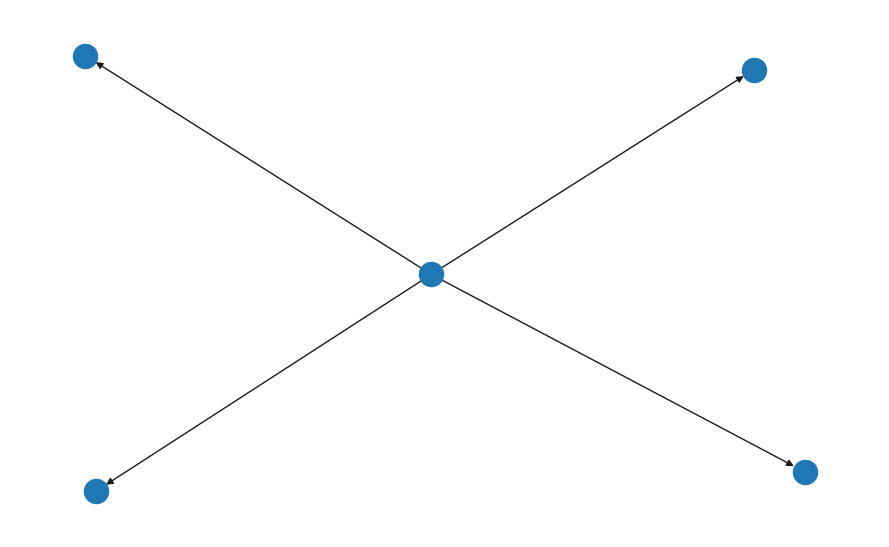

In [6]:
graph_nx = graph_nets.utils_np.graphs_tuple_to_networkxs(x)
nx.draw(graph_nx[0])

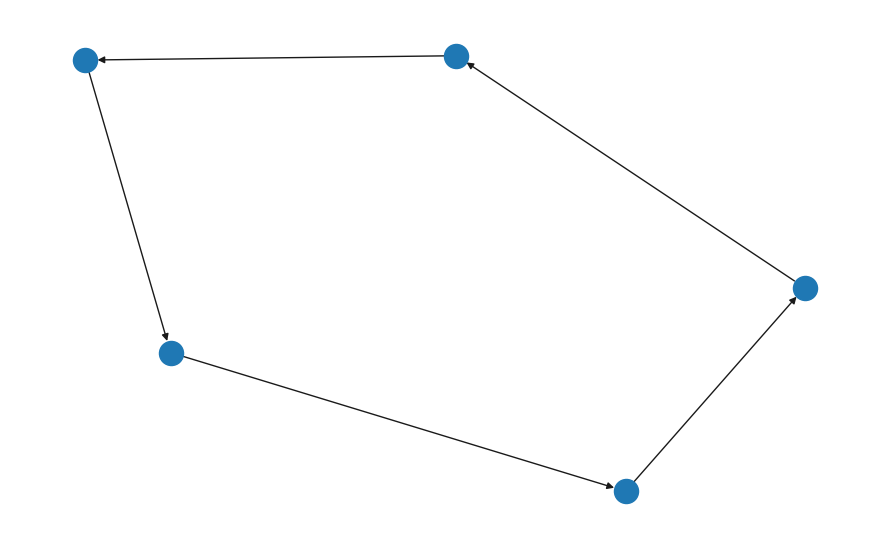

In [7]:
nx.draw(graph_nx[1])

### **How to do this with a molecule?**

Let's now attempt to represent the first molecule in our dataset as a graph.

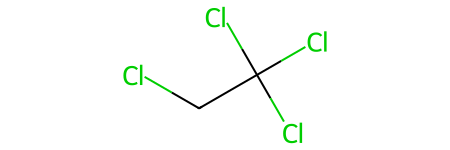

In [8]:
mol = df.mol.iloc[0]
mol

We first need to define two functions

* `get_node_features`: This function takes an `Atom` object as input and returns the atom features. In this case, we will consider a single feature (atom type) and return the one-hot encoding of the atom type.

* `get_edge_features`: This function takes a `Bond` object as input and returns the bond features. Again, we will consider a single feature (bond type) and return the one-hot encoding of the bond type.

Note: the `encode_onehot`is defined as follows
```
def encode_onehot(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return [x == item for item in allowable_set]
```


In [9]:
from graphs import encode_onehot

atom_set = ['C', 'N', 'O', 'Cl', 'other']
def get_node_features(atom):
    values = [encode_onehot(atom.GetSymbol(), atom_set)]
    return np.hstack(values)

def get_edge_features(bond):
    values = [encode_onehot(str(bond.GetBondType()), ['SINGLE', 'DOUBLE', 'TRIPLE', 'AROMATIC', 'other'])]
    return np.hstack(values)


In addition, we need to define two lists: one containing the indices of the sender atoms and another containing the indices of the receiver atoms. Since there is no particular directionality in the interactions between atoms within a molecule, for each pair of atoms A and B, we specify two edges with the same features - one edge pointing from A to B and the other pointing from B to A.

We can now compute all the elements required to define the `GraphTuple` of the first molecule in the dataset.

In [10]:
nodes = np.array([get_node_features(atom) for atom in mol.GetAtoms()])
edges = np.zeros((mol.GetNumBonds() * 2, 5))
senders = []
receivers = []
for index, bond in enumerate(mol.GetBonds()):
    id1 = bond.GetBeginAtom().GetIdx()
    id2 = bond.GetEndAtom().GetIdx()
    bond_arr = get_edge_features(bond)
    edges[index * 2, :] = bond_arr
    edges[index * 2 + 1, :] = bond_arr
    senders.extend([id1, id2])
    receivers.extend([id2, id1])

We store all this elements in a dictionary that can be converted into a `GraphTuple` object

In [11]:
data_dict = {
        'nodes': nodes.astype(np.float32),
        'edges': edges.astype(np.float32),
        'globals': np.array([0.], dtype=np.float32),
        'senders': np.array(senders, np.int32),
        'receivers': np.array(receivers, np.int32)
    }

x = graph_nets.utils_tf.data_dicts_to_graphs_tuple([data_dict])

### **Compute graph features for the molecules in the Delaney dataset**

In the `graph.py` file, we have implemented a more advanced function that allows for the conversion of a list of SMILES into a `GraphTuple` object. This function iterates over all molecules, computes the node and edge features, and fills in the GraphTuple attributes. 

**It's worth noting that this function computes additional features beyond those considered in the previous example. To learn more about the features that are computed, please refer to the code.**



In [ ]:
# get graph tuples
from graphs import MolTensorizer, save_graphstuple

smi_to_graph = MolTensorizer(config.atom_set)
x = smi_to_graph(smiles)
save_graphstuple(data_dir + "features_graph.npz", x, smiles)

### **Splitting molecules**

In order to properly evaluate predictive models, we splite molecules in train, test and validations sets.

In [ ]:
test_size  = 0.2
val_size   = 0.1
train_size = 0.7
##
seed = 83
smi_train, smi_test = train_test_split(smiles, random_state=seed, test_size=test_size)
smi_train, smi_val = train_test_split(smi_train, random_state=seed,
                                      test_size=val_size / (train_size + val_size))


# check split train and validation
for a, b in itertools.combinations([smi_train, smi_val, smi_test], 2):
    assert np.intersect1d(a, b).size == 0, 'Found bad split!'  # ensure no intersection between splits

np.savez_compressed(data_dir + "smi_split.npz", train=smi_train, val=smi_val, test=smi_test)

## **Training a Graph Neural Network**

Before we can proceed with fitting models, we need to set up the stage. We have developed a function for that. 

In [ ]:
from utils import IndexSplit, ArraySplit, ScaledArraySplit
from graphs import get_graphs, load_graphstuple, GraphSplit

def load_task(y_scaler):
    smi_split = np.load(f'{data_dir}smi_split.npz')
    smi_dict  = {key: smi_split[key] for key in smi_split.keys()}
    ##
    y = df[config.target_column].values.reshape(-1, 1)
    ##
    indices = {}
    for key, smi in smi_dict.items():
        indices[key] = np.array(df[np.isin(smiles, smi)].index.tolist())

    split = IndexSplit(**indices)


    loaded_smi, g = load_graphstuple(data_dir + "features_graph.npz")
    smi_to_index = {s: index for index, s in enumerate(loaded_smi)}
    new_indices = np.array([smi_to_index[s] for s in smiles])
    g = get_graphs(g, new_indices)
    x = GraphSplit(g, split)
    y = ScaledArraySplit(y, split, y_scaler)
    
    return smi_dict, x, y

This function returns three objects:

* `smi_dict`: a dictionary containing SMILES for molecules separated into training, validation, and test sets.

* `x`: an object that enables us to retrieve the molecular graphs in the training, validation, and test sets.

* `y`: an object that enables us to retrieve the log-solubility values of the molecules in the training, validation, and test sets.

Notice that in this case we just need to specify the outcome scaler.

In [ ]:
smi_split, x, y = load_task('standard')



We propose to utilize a Graph Network (GN) model to predict the log-solubility of a given molecule, as described in the reference. GNs are a type of functions that operate on graph-structured data. The GN block is the primary computational unit in a Graph Network, and it maps one graph to another. A graph with $N_v$ nodes and $N_e$ edges can be represented as a tuple $G = (\textbf{u}, V, E)$, where $\textbf{u}$ represents the global attribute, $V = \lbrace v_i \rbrace_{i=1:N^v}$ is the set of node attribute vectors, and $E = \lbrace (\textbf{e}_k, r_k, s_k)\rbrace_{k=1:N^e}$ is the set of edges. Here, $\textbf{e}_k$ denotes the edge attribute, $r_k$ is the index of the receiving node, and $s_k$ is the index of the sending node.

The GN block comprises an edge update function $\phi^e$, a node update function $\phi^v$, and a global update function $\phi^u$. It also includes three aggregate functions: $\rho^{e\rightarrow v}$, which aggregates edge attributes per node, $\rho^{e\rightarrow u}$, which aggregates edge attributes globally, and $\rho^{v\rightarrow u}$, which aggregates node attributes globally.

Let's now delve into the GN workflow






### GN block 

When a graph is fed to a GN block, the computations proceed from the edge level to the node level and then to the global level. The following steps are involved:

1. The function $\phi^{e}$ is applied to **all the edges**. This function, when applied to edge $k$ takes as arguments  $(\textbf{e}_k, \textbf{v}_{r_k}, \textbf{v}_{s_k}, \textbf{u})$ and returns the updated edge features $\textbf{e'}_k$. The set of resulting per-edge outputs for node $i$ is denoted as $E'_i = \lbrace (\textbf{e'}_k, r_k, s_k) \rbrace_{r_k = i}$. The set of all per-edge outputs is $E' = \cup_i E'_i$.

2. **For every node** $\rho^{e\rightarrow v}$ is applied to $E'_i$ to aggregate the edge updates for edges that project to vertex $i$. This produces updated and aggregated edge information for node $i$, denoted as $\bf{\overline{e}'_i}$

3. The function $\phi^{v}$ is applied to **all the nodes**. This function, when applied to node $i$ takes as arguments  $(\bf{\overline{e}'_i}, \textbf{v}_{i}, \textbf{u})$ and returns the updated node features $\textbf{v'}_i$. The set of all per-node outputs is denoted as $V' = \lbrace \textbf{v'}_i \rbrace_{i=1:N^v}$

4. The function $\rho^{e\rightarrow u}$ is applied to $E'$ and aggregates all edge updates into $\bf{\overline{e}'}$

5. The function $\rho^{v\rightarrow u}$ is applied to $V'$ and aggregates all node updates into $\bf{\overline{v}'}$

6. The function $\phi^u$ is used. This function takes as arguments  $(\bf{\overline{e}'}, \bf{\overline{v}'}, \bf{u})$ and returns the updated global features $\textbf{u}$.


Each of the functions described can have various parametric forms, but a common choice is to use multilayer perceptrons for the update functions and sums for the aggregate functions.

It's worth noting that GN blocks can be concatenated to allow for more distant neighbors to affect the update of a given node. In a single GN block, only first neighbors are used to update a node. However, when two GN blocks are concatenated, second neighbors can affect the update, and so on.

The output of a Graph Network will depend on the task at hand. In our case, to obtain a property prediction, the output layer takes the updated global features as input an returns an scalar.

The entire architecture can be summarized as follows:

1. Encode the input graph using independent node and edge update functions to match the internal node and edge feature sizes.

2. Apply multiple GN blocks to the embedded graph.

3. Use an output layer to map the updated global features to a property prediction.

Once the architecture is defined, the parameters can be optimized using standard optimizers and loss functions.


With the following lines of code, we define a GNN with 3 GN blocks.

In [ ]:
def get_graph_block(node_size: int,
                    edge_size: int, global_size: int, 
                    index: int):
    """Gets a GNN block based on enum and sizes."""
    name = f'graph_net_{index + 1}'
    use_globals = index != 0
    return graph_nets.modules.GraphNetwork(
        node_model_fn=modules.get_mlp_fn([node_size] * 2),
        edge_model_fn=modules.get_mlp_fn([edge_size] * 2),
        global_model_fn=modules.get_mlp_fn([global_size] * 2),
        edge_block_opt={'use_globals': use_globals},
        node_block_opt={'use_globals': use_globals},
        global_block_opt={'use_globals': use_globals},
        name=name)
    
class GNN(snt.Module):
    """A general graph neural network for graph property prediction."""

    def __init__(self,
                 node_size,
                 edge_size,
                 global_size,
                 n_layers = 3):
        super(GNN, self).__init__()

        # Graph encoding step, basic linear mapping.
        self.encode = graph_nets.modules.GraphIndependent(
            node_model_fn=lambda: snt.Linear(node_size),
            edge_model_fn=lambda: snt.Linear(edge_size))
        # GN blocks.
        gnn_layers = [
            get_graph_block(
                node_size,
                edge_size,
                global_size,
                index)
            for index in range(0, n_layers)
        ]
        self.gnn = snt.Sequential(gnn_layers)
        self.pred_layer = modules.get_pred_layer(1, 'identity')

    def embed(self, x):
        return self.gnn(self.encode(x)).globals

    def __call__(self, x):
        return self.pred_layer(self.embed(x))

    def train(self, x, y, lr=1e-3, patience=20, epochs=2000,
              batch_size = 256, verbose=True):

        optimizer = tf.keras.optimizers.Adam(lr)
        # optimizer = tf.keras.optimizers.experimental.SGD(learning_rate=0.1, jit_compile=False)
        loss_fn = tf.keras.losses.MeanSquaredError()
        main_metric, metric_fn = ('R^2', r2_score)

        y_train, y_val, y_test = y.scaled_train, y.scaled_val, y.scaled_test

        # train the model
        early_stop = training.EarlyStopping(self, patience=patience)
        stop_metric = f'val_{main_metric}'
        pbar = tqdm(range(epochs), disable=not verbose)
        stats = []

        for _ in pbar:
            training.train_step(self, x.train, y_train, optimizer, loss_fn, 
                                batch_size)

            result = {}
            for inputs, target, prefix in [
                (x.train, y_train, 'train'),
                (x.val, y_val, 'val'),
                (x.test, y_test, 'test')
            ]:
                output = self(inputs)
                result[f'{prefix}_{main_metric}'] = metric_fn(target, output)
                result[f'{prefix}_loss'] = loss_fn(target, output).numpy()
            stats.append(result)
            
            pbar.set_postfix(stats[-1])
            if early_stop.check_criteria(stats[-1][stop_metric]):
                break

        early_stop.restore_best()
        best_step = early_stop.best_step
        print(f'Early stopped at {best_step} with {stop_metric}={stats[best_step][stop_metric]:.3f}')

    def predict(self, x,
                return_embeddings = False):
                
        assert isinstance(x, GraphsTuple), 'GNN requires graph tuples input.'

        # predict values and the standard deviation
        y_pred = self.__call__(x)

        y_pred = y_pred.numpy()
  

        if return_embeddings:
            embeddings = self.embed(x).numpy()
            return y_pred, embeddings

        return y_pred


We now train the model using the training set molecules.

In [ ]:
model = GNN(node_size=50, edge_size=20, global_size=150, n_layers = 3)
model.train(x, y)

  7%|▋         | 133/2000 [05:14<1:13:40,  2.37s/it, train_R^2=0.952, train_loss=0.0477, val_R^2=0.895, val_loss=0.101, test_R^2=0.914, test_loss=0.0962]

Restoring checkpoint at step 113 with best value at 0.914
Early stopped at 113 with val_R^2=0.914


We can make predictions on the test set molecules using:

In [ ]:
y_pred = model.predict(x.test)

We save the results for later evaluation

In [ ]:
np.savez_compressed(f'{data_dir}predictions_GNN_features_graph.npz', y_pred=y_pred, y_true=y.scaled_test)

## **Evaluating the Graph Neural Network**

The GNN model provides point forecast.
For evaluating deterministic predictions, we can use the usual metrics. We use the R2 score

R2 score: 0.9246625947390259


<Axes: >

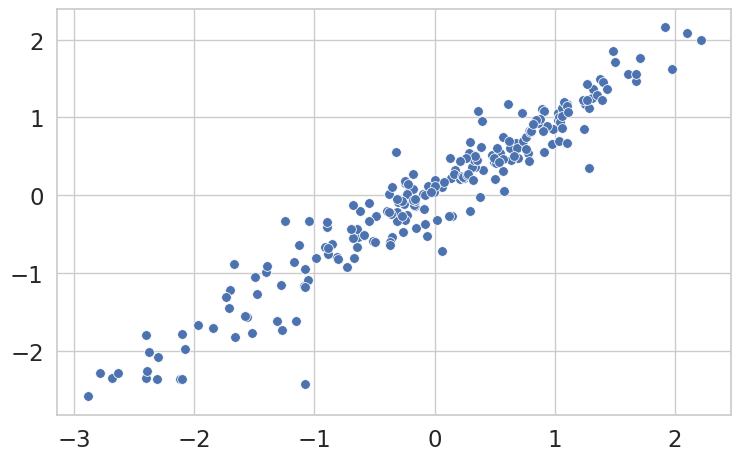

In [ ]:
preds = np.load(f'{data_dir}predictions_GNN_features_graph.npz')
preds = {key: preds[key] for key in preds.keys()}

print("R2 score:", r2_score(preds["y_true"].squeeze(), preds["y_pred"].squeeze()))
sns.scatterplot(x = preds["y_true"].squeeze(), y = preds["y_pred"].squeeze())

# **Your turn**

With the knowledge we have acquired, you can integrate Graph Neural Networks (GNN) with Gaussian Processes (GPs) to generate probabilistic forecasts.

To implement this approach, you can utilize the global embeddings generated by the GNN as descriptors for the GP model. By training the GP with these descriptors and utilizing the RBF kernel, you can obtain the desired probabilistic forecasts.



